In [1]:
# for loading/processing the images  
from keras.preprocessing.image import load_img 
from keras.preprocessing.image import img_to_array 
from keras.applications.vgg16 import preprocess_input 

# models 
from keras.applications.vgg16 import VGG16 
from keras.models import Model

# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# for everything else
import os
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import pandas as pd
import pickle
from PIL import Image

In [2]:
path = r"/Users/taylorlast/Documents/GitHub/elephent-footprints-VGG16/Elephant Prints"
# change the working directory to the path where the images are located
os.chdir(path)

# this list holds all the image filename
elephants = []

# creates a ScandirIterator aliased as files
with os.scandir(path) as files:
  # loops through each file in the directory
    for file in files:
        if file.name.endswith('.JPG'):
          # adds only the image files to the flowers list
            elephants.append(file.name)

In [3]:
model = VGG16()
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)

def extract_features(file, model):
    # load the image as a 224x224 array
    img = load_img(file, target_size=(224,224))
    # convert from 'PIL.Image.Image' to numpy array
    img = np.array(img) 
    # reshape the data for the model reshape(num_of_samples, dim 1, dim 2, channels)
    reshaped_img = img.reshape(1,224,224,3) 
    # prepare image for model
    imgx = preprocess_input(reshaped_img)
    # get the feature vector
    features = model.predict(imgx, use_multiprocessing=True)
    return features



In [8]:

data = {}
p = r"/Users/taylorlast/Documents/UGA_FourthYear/STAT_5020/elephant_model.pkl"

# lop through each image in the dataset
for elephant in elephants:
    # try to extract the features and update the dictionary
    try:
        feat = extract_features(elephant,model)
        data[elephant] = feat
    # if something fails, save the extracted features as a pickle file (optional)
    except:
        with open(p,'wb') as file:
            pickle.dump(data,file)
            
data

{'IMG_9408.JPG': array([[0.        , 4.2330136 , 0.        , ..., 0.        , 0.40847495,
         1.4430516 ]], dtype=float32),
 'IMG_9421.JPG': array([[0.       , 3.3945851, 0.       , ..., 0.       , 2.3641908,
         1.9675488]], dtype=float32),
 'IMG_9426.JPG': array([[0.       , 2.8541174, 0.       , ..., 0.       , 1.4207091,
         0.5168841]], dtype=float32),
 'IMG_9427.JPG': array([[0.       , 3.4708996, 0.       , ..., 0.       , 1.0064788,
         1.4894588]], dtype=float32),
 'IMG_9419.JPG': array([[0.       , 3.2149274, 0.1372199, ..., 0.       , 1.1945081,
         0.677142 ]], dtype=float32),
 'IMG_9274.JPG': array([[0.        , 2.1749837 , 0.        , ..., 0.        , 0.92098063,
         0.79583836]], dtype=float32),
 'IMG_9398.JPG': array([[0.       , 1.1363634, 0.       , ..., 0.       , 1.9407496,
         1.5893111]], dtype=float32),
 'IMG_9401.JPG': array([[0.       , 1.3685584, 0.       , ..., 0.       , 2.0371869,
         1.9483273]], dtype=float32),
 'IM

In [20]:
# get a list of the filenames
filenames = np.array(list(data.keys()))

# get a list of just the features
feat = np.array(list(data.values()))

# reshape so that there are 210 samples of 4096 vectors
feat = feat.reshape(-1,4096)

# get the unique labels (from the flower_labels.csv)
# df = pd.read_csv('flower_labels.csv')
# label = df['label'].tolist()
# unique_labels = list(set(label))

# reduce the amount of dimensions in the feature vector
pca = PCA(n_components=20, random_state=22)
pca.fit(feat)
x = pca.transform(feat)


In [16]:
# cluster feature vectors
kmeans = KMeans(n_clusters=6,n_jobs=-1, random_state=22)
kmeans.fit(x)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:973: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


KMeans(n_clusters=6, n_jobs=-1, random_state=22)

In [25]:
# holds the cluster id and the images { id: [images] }
groups = {}
for file, cluster in zip(filenames,kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

In [23]:
# function that lets you view a cluster (based on identifier)        
def view_cluster(cluster):
    plt.figure(figsize = (25,25));
    # gets the list of filenames for a cluster
    files = groups[cluster]
    # only allow up to 30 images to be shown at a time
    if len(files) > 30:
        print(f"Clipping cluster size from {len(files)} to 30")
        files = files[:29]
    # plot each image in the cluster
    for index, file in enumerate(files):
        plt.subplot(10,10,index+1);
        img = load_img(file)
        img = np.array(img)
        plt.imshow(img)
        plt.axis('off')
        
    
# this is just incase you want to see which value for k might be the best 
# sse = []
# list_k = list(range(3, 50))

# for k in list_k:
#     km = KMeans(n_clusters=k, random_state=22, n_jobs=-1)
#     km.fit(x)
    
#     sse.append(km.inertia_)

# # Plot sse against k
# plt.figure(figsize=(6, 6))
# plt.plot(list_k, sse)
# plt.xlabel(r'Number of clusters *k*')
# plt.ylabel('Sum of squared distance');

In [39]:
groups

{0: ['IMG_9408.JPG',
  'IMG_9427.JPG',
  'IMG_9274.JPG',
  'IMG_9404.JPG',
  'IMG_9411.JPG',
  'IMG_9405.JPG'],
 3: ['IMG_9421.JPG', 'IMG_9401.JPG', 'IMG_9414.JPG', 'IMG_9402.JPG'],
 4: ['IMG_9426.JPG', 'IMG_9403.JPG', 'IMG_9406.JPG'],
 2: ['IMG_9419.JPG', 'IMG_9416.JPG', 'IMG_9407.JPG', 'IMG_9410.JPG'],
 1: ['IMG_9398.JPG', 'IMG_9400.JPG'],
 5: ['IMG_9399.JPG']}

None
None
None
None
None
None


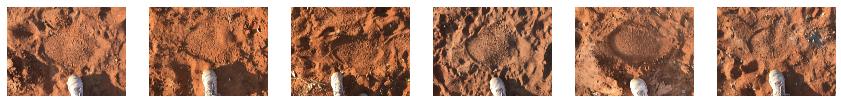

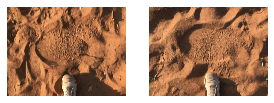

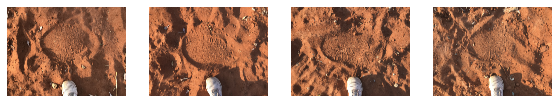

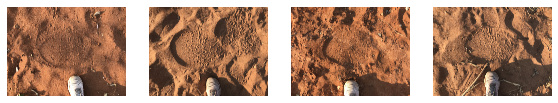

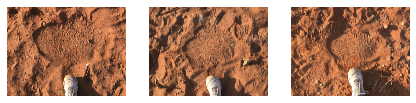

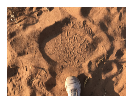

In [43]:
for cluster in range(6):
    print(view_cluster(cluster))